In [12]:
using RDatasets, LinearAlgebra

Let's compare how Poisson EPCA performs against vanilla PCA on compositional data. For this example, we use the [Chemical Composition of Pottery](https://vincentarelbundock.github.io/Rdatasets/doc/carData/Pottery.html) dataset from RDatasets. More information about the dataset can be found on the doc. 

In [13]:
df = dataset("car", "Pottery")
labels = Vector(df[:, 1])
compositions = Matrix(df[:, 2:end])
normalized_compositions = (compositions ./ sum(compositions, dims=2))

26×5 Matrix{Float64}:
 0.546282  0.265554   0.163126   0.00569044   0.0193475
 0.560976  0.287805   0.139431   0.00487805   0.00691057
 0.563707  0.273745   0.149807   0.00501931   0.00772201
 0.48299   0.267535   0.236875   0.00671987   0.00587988
 0.518797  0.265414   0.200752   0.0075188    0.0075188
 0.518554  0.297812   0.165081   0.00808754   0.0104662
 0.531579  0.224211   0.224211   0.0105263    0.00947368
 0.490901  0.244604   0.250106   0.00761744   0.00677105
 0.511521  0.252995   0.208295   0.0133641    0.0138249
 0.478059  0.246878   0.257938   0.0099893    0.00713521
 ⋮                                            
 0.837308  0.126656   0.0333863  0.000529942  0.00211977
 0.889328  0.0741107  0.0331028  0.000494071  0.00296443
 0.873362  0.0912179  0.0329937  0.000485201  0.00194081
 0.896552  0.0650862  0.0310345  0.00301724   0.00431034
 0.907692  0.0574359  0.0287179  0.00307692   0.00307692
 0.905045  0.0563798  0.0331355  0.00296736   0.0024728
 0.917079  0.0505217  0.

In [14]:
using ExpFamilyPCA

indim = size(normalized_compositions)[2]
epca = PoissonEPCA(indim, 3)
A1 = fit!(epca, normalized_compositions; verbose=true, maxiter=20)
Xre1 = decompress(epca, A1)

Iteration: 1/20 | Loss: 9.604824248848582
Iteration: 10/20 | Loss: 9.583036480751733
Loss converged early. Stopping iteration.


26×5 Matrix{Float64}:
 0.566181  0.268965   0.170402   0.00885115  0.00991993
 0.557624  0.28788    0.137588   0.00567141  0.00720329
 0.558901  0.273893   0.147033   0.00649344  0.00782449
 0.469471  0.267062   0.229974   0.00863924  0.00835236
 0.51176   0.265187   0.197164   0.00850226  0.00881691
 0.528664  0.298326   0.170023   0.00703975  0.00825696
 0.525     0.224015   0.22072    0.0115848   0.0105712
 0.476109  0.244287   0.242483   0.0100677   0.00912439
 0.527533  0.253636   0.216397   0.0111176   0.0108585
 0.469702  0.246294   0.25398    0.0104948   0.00934763
 ⋮                                           
 0.833051  0.126674   0.0311199  0.00147832  0.00250914
 0.886331  0.074453   0.0310462  0.00193525  0.00256551
 0.868103  0.0912686  0.0301458  0.00166704  0.0024625
 0.9026    0.0654025  0.0339289  0.00245306  0.00294464
 0.91189   0.057467   0.0309984  0.00219321  0.00257778
 0.905603  0.0562144  0.033566   0.00248982  0.00279522
 0.915149  0.0509053  0.0275985  0.0018

In [15]:
using MultivariateStats

In [16]:
M = fit(PCA, normalized_compositions'; maxoutdim=3)
A2 = predict(M, normalized_compositions')'
Xre2 = reconstruct(M, A2')'

26×5 adjoint(::Matrix{Float64}) with eltype Float64:
 0.548914  0.26842    0.16606    0.00784425  0.00876223
 0.559873  0.286644   0.138154   0.00684533  0.00848357
 0.562796  0.272794   0.148743   0.00719938  0.00846742
 0.480504  0.264907   0.234007   0.0104238   0.010159
 0.517715  0.264269   0.199504   0.0091052   0.00940717
 0.518973  0.298261   0.165557   0.00793266  0.009276
 0.53184   0.224484   0.224516   0.00991597  0.0092447
 0.488865  0.242455   0.247753   0.0108673   0.0100594
 0.514062  0.255681   0.211227   0.0095215   0.00950786
 0.476694  0.245425   0.256377   0.011207    0.0102967
 ⋮                                           
 0.836386  0.125686   0.0323177  0.00222731  0.00338237
 0.888994  0.0737728  0.0327001  0.00205473  0.00247803
 0.872608  0.0904268  0.0321149  0.00209245  0.00275822
 0.897485  0.0660772  0.032104   0.00200424  0.00232996
 0.90836   0.0581385  0.0294914  0.00187595  0.00213433
 0.905423  0.0567743  0.033578   0.00202694  0.00219807
 0.916919  0

In [17]:
using Statistics

In [18]:
function shift_and_normalize_rows(matrix)
    # NOTE: Following footnote (4) in Roy et al. (2015), we "shift the reconstruction to be non-negative, and rescale it to sum to 1."
    shifted_matrix = matrix .- minimum(matrix, dims=2)
    normalized_matrix = shifted_matrix ./ sum(shifted_matrix, dims=2)
    return normalized_matrix
end

shift_and_normalize_rows (generic function with 1 method)

In [19]:
kl(p, q; ϵ=eps()) = sum(@. p * (log(p + ϵ) - log(q + ϵ)))

means1 = []
means2 = []
for outdim in 1:indim
    @show outdim
    
    # fit EPCA
    epca = PoissonEPCA(indim, outdim)
    A1 = fit!(epca, normalized_compositions; verbose=false, maxiter=100)
    Xre1 = decompress(epca, A1)

    # fit PCA
    M = fit(PCA, normalized_compositions'; maxoutdim=outdim)
    A2 = predict(M, normalized_compositions')'
    Xre2 = reconstruct(M, A2')'

    X1 = shift_and_normalize_rows(Xre1)
    X2 = shift_and_normalize_rows(Xre2)
    
    kl1 = []
    kl2 = []
    for (p1, p2, q) in zip(eachrow(X1), eachrow(X2), eachrow(normalized_compositions))
        push!(kl1, kl(p1, q))
        push!(kl2, kl(p2, q))
    end
    @show mean(kl1)
    @show mean(kl2)
    push!(means1, mean(kl1))
    push!(means2, mean(kl2))
end

outdim = 1
mean(kl1) = 0.04816594932803058
mean(kl2) = 0.015080791434203116
outdim = 2
mean(kl1) = 0.014175305774268248
mean(kl2) = 0.011338712277564039
outdim = 3
mean(kl1) = 0.011104736792543302
mean(kl2) = 0.011338712277564039
outdim = 4
mean(kl1) = 0.007423290780327476
mean(kl2) = 0.011338712277564039
outdim = 5
mean(kl1) = 0.007728025081430528
mean(kl2) = 0.011338712277564039


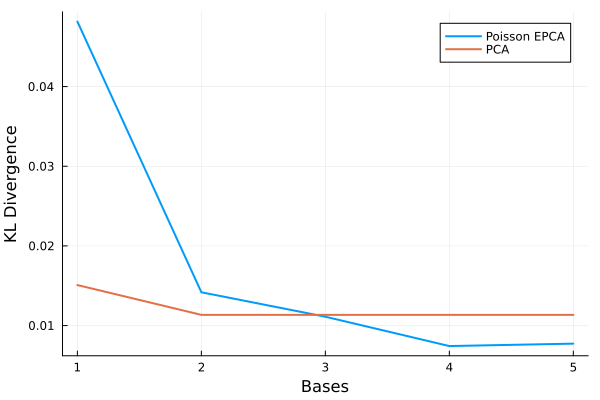

In [20]:
using Plots

# Plotting
plot(1:indim, means1, label="Poisson EPCA", xlabel="Bases", ylabel="KL Divergence", linewidth=2)
plot!(1:indim, means2, label="PCA", linewidth=2)